<a href="https://colab.research.google.com/github/PUC-RecSys-Class/RecSysPUC-2020/blob/master/practicos/pyRecLab_iKNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<a href="https://www.youtube.com/watch?v=Tu9p4i8vxdA" target="_parent"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/0/09/YouTube_full-color_icon_%282017%29.svg/71px-YouTube_full-color_icon_%282017%29.svg.png" alt="Open In Colab"/></a>


# Tutorial pyreclab UserKNN

En este práctico vamos a utilizar la biblioteca de Python [pyreclab](https://github.com/gasevi/pyreclab) desarrollado por los Laboratorios IALab y SocVis de la Pontificia Universidad Católica de Chile, para aprender sobre User KNN (Filtrado colaborativo basado en usuarios)

**Profesor**: Denis Parra
**Ayudantes** Andrés Villa, Francisca Cattan, Vladimir Araujo, Andrés Carvallo, Manuel Cartagena.


# Índice

>[Tutorial pyreclab UserKNN](#scrollTo=NC-ceGb8LRLT)

>[Índice](#scrollTo=2j02H66f87eV)

>[Descargando la información](#scrollTo=9qKTQ2V5VKSX)

>[Revisar archivos descargados](#scrollTo=liJ3L2kl4g1o)

>>[Como ver la información de una o más películas](#scrollTo=jqXxj773Foo8)

>>[Preparar entorno](#scrollTo=P3K5VPZoGSYX)

>>[UserKNN](#scrollTo=2e0ZeZXzMhU3)

>>[Predecir el rating que le dará un usuario a un cierto item](#scrollTo=lEx2TVc1B5wk)

>>[Generar una lista de recomendaciones para un usuario](#scrollTo=dIVXNsQ8CCJV)

>>[Explorar los hiperparámetros del modelo UserKnn](#scrollTo=6_Kp3zRwJ9gv)

>>>[Evaluar en base a error de prediccion (RMSE y MAE)](#scrollTo=g55SDLmqCpUo)



# Descargando la información

Ejecutar cada celda presionando el botón de **Play** o presionando Ctrl+Enter (Linux y Windows) o Command+Enter (OSX) para descargar las bases de datos

In [27]:
!curl -L -o "u1.base" "https://drive.google.com/uc?export=download&id=1bGweNw7NbOHoJz11v6ld7ymLR8MLvBsA"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    611      0 --:--:-- --:--:-- --:--:--   611
100 1546k  100 1546k    0     0  1817k      0 --:--:-- --:--:-- --:--:--  137M


In [28]:
!curl -L -o "u1.test" "https://drive.google.com/uc?export=download&id=1f_HwJWC_1HFzgAjKAWKwkuxgjkhkXrVg"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    928      0 --:--:-- --:--:-- --:--:--   928
100  385k  100  385k    0     0   585k      0 --:--:-- --:--:-- --:--:--  585k


In [29]:
!curl -L -o "u.item" "https://drive.google.com/uc?export=download&id=10YLhxkO2-M_flQtyo9OYV4nT9IvSESuz"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0     39      0 --:--:--  0:00:09 --:--:--   107
100  230k  100  230k    0     0  23589      0  0:00:10  0:00:10 --:--:-- 23589


Los archivos **u1.base** y **u1.test** tienen tuplas {usuario, item, rating, timestamp}, que es la información de preferencias de usuarios sobre películas en una muestra del dataset [movielens](https://grouplens.org/datasets/movielens/).

# Revisar archivos descargados

Revisemos cómo es uno de estos archivos:

In [30]:
import pandas as pd

train_file = pd.read_csv('u1.base', sep='\t', names = ['userid', 'itemid', 'rating', 'timestamp'], header=None)

train_file.head()

,userid,itemid,rating,timestamp
0,1,3,4,878542960
1,1,4,3,876893119
2,1,5,3,889751712
3,1,6,5,887431973
4,1,7,4,875071561


In [31]:
# Ver la o las filas específicas del item con id = 1653
train_file[train_file['itemid'] == 1653]

,userid,itemid,rating,timestamp
54444,675,1653,5,889489913


Por otra parte, para obtener información adicional de cada película tal como *título*, *fecha de lanzamient*o, *género*, etc., cargaremos el archivo de items descargado ( *u.item* ) para poder mapear cada identificador de ítem al conjunto de datos que lo describe.
Revisemos el contenido de este archivo

In [32]:
info_cols = [ 'movieid', 'title', 'release_date', 'video_release_date', 'IMDb_URL', \
              'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', \
              'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', \
              'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western' ]

pd.options.display.max_columns = None

info_file = pd.read_csv('u.item', sep='|', index_col = 0, names = info_cols, header=None, encoding='latin-1')

info_file.head()

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


El comando `pd.options.display.max_columns = None` permite que la tabla se pueda mostrar completamente de forma horizontal, es decir, que muestre todas sus columnas.

In [33]:
info_file.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1682 entries, 1 to 1682
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               1682 non-null   object 
 1   release_date        1681 non-null   object 
 2   video_release_date  0 non-null      float64
 3   IMDb_URL            1679 non-null   object 
 4   unknown             1682 non-null   int64  
 5   Action              1682 non-null   int64  
 6   Adventure           1682 non-null   int64  
 7   Animation           1682 non-null   int64  
 8   Children            1682 non-null   int64  
 9   Comedy              1682 non-null   int64  
 10  Crime               1682 non-null   int64  
 11  Documentary         1682 non-null   int64  
 12  Drama               1682 non-null   int64  
 13  Fantasy             1682 non-null   int64  
 14  Film-Noir           1682 non-null   int64  
 15  Horror              1682 non-null   int64  
 16  Musica

In [34]:
info_file.describe()

,video_release_date,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
count,0.0,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.00000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000
mean,NaN,0.001189,0.149227,0.080262,0.024970,0.072533,0.300238,0.064804,0.029727,0.431034,0.01308,0.014269,0.054697,0.033294,0.036266,0.146849,0.060048,0.149227,0.042212,0.016052
std,NaN,0.034473,0.356418,0.271779,0.156081,0.259445,0.458498,0.246253,0.169882,0.495368,0.11365,0.118632,0.227455,0.179456,0.187008,0.354061,0.237646,0.356418,0.201131,0.125714
min,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Con las funciones `info` y `describe` de ***pandas*** es una buena forma de analizar a grandes rasgos un dataset.

## Como ver la información de una o más películas
Para esto se hace 2 pasos, 
1. Determinar los índices de las películas
2. Pedir a `info_file` las columnas
3. (adicional) Indicar alguna columna en específico

In [35]:
# Ejemplo de cómo visualizar titulos de peliculas en base a sus IDs

# Paso 1
pelis = [5,4,1]
# Paso 2
info_file.loc[pelis]

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0


Para éste código:
1. `pelis = [5,4,1]` indica que queremos las películas cuyo índice son 5, 4 y 1
2. `info_file.loc[pelis]` el método `loc` permite acceder a esas columna
A continuación se verá como obtener una columna en específico. Para esto solo es necesario agregar corchetes y el nombre de la columna

In [36]:
# Paso 3 (opcional)
info_file.loc[pelis]['title']

movieid
5       Copycat (1995)
4    Get Shorty (1995)
1     Toy Story (1995)
Name: title, dtype: object

## Preparar entorno
Primero es necesario instalar una librería para realizar recomendaciones. Esta se llama [***pyreclab***](https://github.com/gasevi/pyreclab)

In [37]:
!pip install pyreclab

Luego necesitamos importar pyreclab y numpy, librerías que utilizaremos en este práctico

In [38]:
import pyreclab
import numpy as np

## UserKNN

Probar método de recomendación basado en ***UserKNN***

In [39]:
# Declarar el objeto recomendador UserKnn
myUserKnn = pyreclab.UserKnn(dataset='u1.base',
                             dlmchar=b'\t',
                             header=False,
                             usercol=0,
                             itemcol=1,
                             ratingcol=2)

Se puede ver que al objeto recomendador le estamos entregando:
* ***dataset***: La ruta al dataset, en este caso está en la misma carpeta que este notebook
* ***dlmchar***: El delimitador del archivo, en este caso las columnas estan separadas por un tab (\t)
* ***header***: Si el dataset tiene una fila de header (por ejemplo los nombres de las columnas)
* ***usercol***: número de cuál columna corresponde a los usuarios
* ***itemcol***: número de cuál columna corresponde a los items
* ***ratingcol***: número de cuál columna corresponde a los ratings

In [40]:
# Entrenamos el modelo con los datos existentes
# Recuerde que en este método puede probar el parámetro k de cantidad de vecinos
# Así como la métrica de similaridad (pearson, cosine)
myUserKnn.train(k=7, similarity='pearson')

## Predecir el rating que le dará un usuario a un cierto item

Según el modelo de recomendación UserKnn, qué rating le dará el usuario 457 al item 37?



In [41]:
myUserKnn.predict("457", "37")

3.25232195854187

## Generar una lista de recomendaciones para un usuario

Generar lista de 5 recomendaciones para el usuario con ID 457. Indique qué películas son con todas sus columnas. (Recuerde el comando `loc` vista anteriormete)

In [42]:
reclist_userKnn = myUserKnn.recommend("457", 5)
pelis_userKnn = np.array(reclist_userKnn).astype(int)
info_file.loc[pelis_userKnn]['title']

movieid
814            Great Day in Harlem, A (1994)
1491                 Tough and Deadly (1995)
1367                            Faust (1994)
1463                        Boys, Les (1997)
1467    Saint of Fort Washington, The (1993)
Name: title, dtype: object

## Explorar los hiperparámetros del modelo UserKnn

Uno de los parámetros que vamos a explorar es el número de vecinos escogidos (Items), para esto calculamos el error del modelo con varios valores de vecinos y observamos cómo es el comportamiento del error.

In [43]:
k_values = [5, 10, 30, 50] # definir distintos valores de vecinos (k)
mae_values = [] # para almacenar resultados de MAE
rmse_values = [] # para almacenar valores de RMSE

for k in k_values:  
  myUserKnn.train(k,'cosine')
  predlist, mae, rmse = myUserKnn.test( input_file = 'u1.test',dlmchar = b'\t', header = False, usercol = 0, itemcol = 1, ratingcol = 2, output_file = 'predictions.csv' )
  rmse_values.append(rmse)
  mae_values.append(mae)

print('RMSE:', rmse_values)
print('MAE:', mae_values)

RMSE: [0.9892174900701061, 0.9598961339770828, 0.9481774437287052, 0.9493413825750796]
MAE: [0.7721242960899395, 0.7492370630025902, 0.7389477584341893, 0.7409246562525648]


### Evaluar en base a error de prediccion (RMSE y MAE)

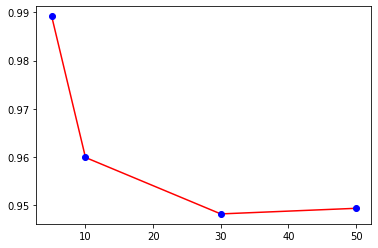

In [44]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(k_values, rmse_values, 'r-')
plt.plot(k_values, rmse_values, 'bo')
plt.show()

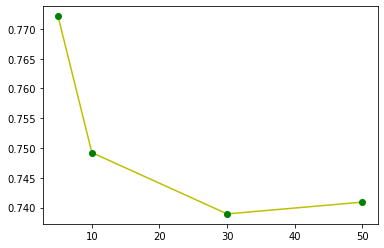

In [45]:
plt.plot(k_values, mae_values, 'y-')
plt.plot(k_values, mae_values, 'go')
plt.show()

Según los resultados: ¿ qué numero de vecinos es mejor para hacer recomendaciones con un menor error de predicción ?

Podemos observar que el menor error se da con **k=30**, por lo tanto podemos reentrenar con este valor y ver loa resultados.

In [46]:
myUserKnn.train(k=30, similarity='cosine')

In [47]:
reclist_userKnn = myUserKnn.recommend("457", 5)
pelis_userKnn = np.array(reclist_userKnn).astype(int)
info_file.loc[pelis_userKnn]['title']

movieid
814              Great Day in Harlem, A (1994)
1463                          Boys, Les (1997)
1536                      Aiqing wansui (1994)
1512    World of Apu, The (Apur Sansar) (1959)
1467      Saint of Fort Washington, The (1993)
Name: title, dtype: object